In [1]:
#Here I want to do a quick time series analysis of AllState stock, and maybe Progressive

#Standard Imports

import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
import pandas_datareader as pdr

#Time series tools
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA

plt.style.use('ggplot')
%matplotlib inline

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1769 entries, 2015-01-02 to 2022-01-10
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1769 non-null   float64
 1   Low        1769 non-null   float64
 2   Open       1769 non-null   float64
 3   Close      1769 non-null   float64
 4   Volume     1769 non-null   float64
 5   Adj Close  1769 non-null   float64
dtypes: float64(6)
memory usage: 96.7 KB


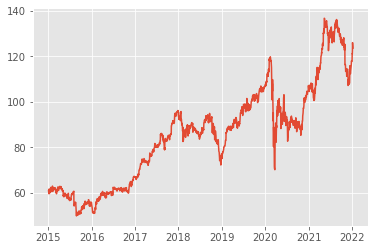

In [2]:
#Let's grab some AllState stock data and plot it

allstate = pdr.get_data_yahoo('ALL',
                          start = dt.datetime(2015, 1, 1),
                          end = dt.datetime(2022, 1, 10))
allstate.info()
allstate.head()

plt.plot(allstate['Adj Close'])
plt.show()

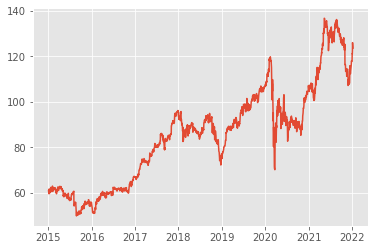

In [3]:
#Now this plot is from 1993 until 2022, so let's go ahead and restrict that data to 2015 onward
allstate = allstate.loc['2015-01-01':,]
allstate.head()
plt.plot(allstate['Adj Close'])
plt.show()


In [4]:
#From here on out, we will look only at the daily adj closing price
#Let's go ahead and check out the basic summary stats

allstate = allstate[['Adj Close']]
allstate.shape
allstate.info()
allstate.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1769 entries, 2015-01-02 to 2022-01-10
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  1769 non-null   float64
dtypes: float64(1)
memory usage: 27.6 KB


,Adj Close
count,1769.000000
mean,85.463692
std,21.689731
min,49.872257
25%,62.166950
50%,87.235237
75%,97.807999
max,136.659546


            Adj Close
Date                 
2015-01-02   0.000000
2015-01-05  -0.019823
2015-01-06  -0.000727
2015-01-07   0.016453
2015-01-08   0.019195
...               ...
2022-01-04   0.024182
2022-01-05  -0.000908
2022-01-06   0.011403
2022-01-07   0.029003
2022-01-10  -0.019135

[1769 rows x 1 columns]


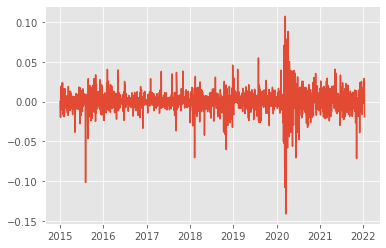

In [5]:
#Looking at daily percent change in the price
daily_pct_change = allstate.pct_change()
daily_pct_change.fillna(0, inplace = True)
print(daily_pct_change)
plt.plot(daily_pct_change)
plt.show()

            Adj Close
Date                 
2015-01-02        NaN
2015-01-05  -0.020022
2015-01-06  -0.000727
2015-01-07   0.016319
2015-01-08   0.019013
...               ...
2022-01-04   0.023894
2022-01-05  -0.000909
2022-01-06   0.011339
2022-01-07   0.028591
2022-01-10  -0.019320

[1769 rows x 1 columns]


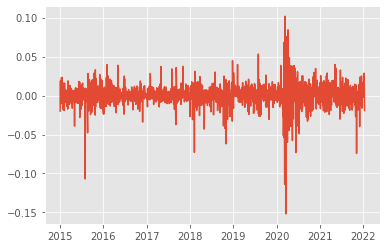

In [6]:
#Looking at daily log returns
daily_log_returns = np.log(allstate.pct_change() + 1)
print(daily_log_returns)
plt.plot(daily_log_returns)
plt.show()

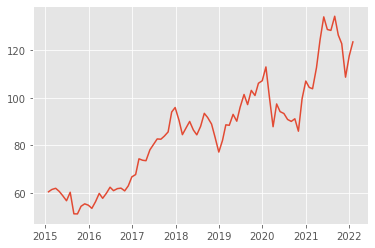

            Adj Close
Date                 
2015-01-30        NaN
2015-02-27   0.015891
2015-03-31   0.008074
2015-04-30  -0.021217
2015-05-29  -0.029269
...               ...
2021-09-30  -0.058915
2021-10-29  -0.028592
2021-11-30  -0.114657
2021-12-31   0.082138
2022-01-31   0.050064

[85 rows x 1 columns]


In [7]:
#Looking at monthly returns
monthly = allstate.resample('BM').apply(lambda x: x[-1])
#BM stands for business months and is slightly different than standard months
plt.plot(monthly)
plt.show()
print(monthly.pct_change())
#This plot is a lot less crowded!

            Adj Close
Date                 
2015-01-31        NaN
2015-05-31   0.001421
2015-09-30  -0.088566
2016-01-31  -0.027718
2016-05-31   0.077580
2016-09-30   0.048875
2017-01-31   0.049199
2017-05-31   0.153355
2017-09-30   0.108458
2018-01-31   0.105673
2018-05-31  -0.033272
2018-09-30   0.017479
2019-01-31  -0.076241
2019-05-31   0.081075
2019-09-30   0.097968
2020-01-31   0.076635
2020-05-31  -0.077467
2020-09-30  -0.060451
2021-01-31   0.072995
2021-05-31   0.190748
2021-09-30   0.117774
2022-01-31  -0.094505


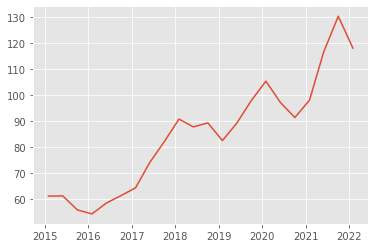

In [8]:
#I want to see the quarterly returns as well, so much is done quarterly
#convert to mean so the object is no longer a resample object, summarizes information, and allows for additional work
quarterly = allstate.resample('4M').mean()
print(quarterly.pct_change())
plt.plot(quarterly)
plt.show() 
#And of course this is much smoother! =)

            Adj Close
Date                 
2015-01-02        NaN
2015-01-05  -0.019823
2015-01-06  -0.000727
2015-01-07   0.016453
2015-01-08   0.019195
...               ...
2022-01-04   0.024182
2022-01-05  -0.000908
2022-01-06   0.011403
2022-01-07   0.029003
2022-01-10  -0.019135

[1769 rows x 1 columns]
            Adj Close
Date                 
2015-01-02        NaN
2015-01-05        NaN
2015-01-06        NaN
2015-01-07  -4.107265
2015-01-08  -3.953099
...               ...
2022-01-04  -3.722148
2022-01-05        NaN
2022-01-06  -4.473869
2022-01-07  -3.540348
2022-01-10        NaN

[1769 rows x 1 columns]


array([[<AxesSubplot:title={'center':'Adj Close'}>]], dtype=object)

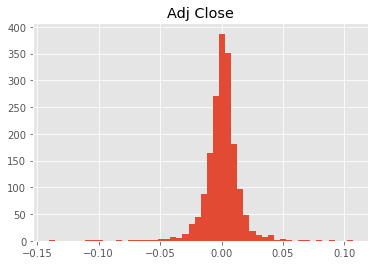

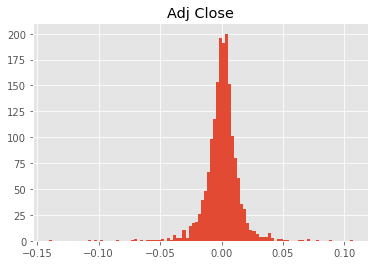

In [9]:
#Time for a more detailed look at the returns

daily_pct_change = allstate / allstate.shift(1) - 1
print(daily_pct_change)

daily_log_returns = np.log(daily_pct_change)
print(daily_log_returns)

daily_pct_change.hist(bins = 50)
daily_pct_change.hist(bins = 100)

            Adj Close
Date                 
2015-01-02        NaN
2015-01-05   0.980177
2015-01-06   0.979464
2015-01-07   0.995579
2015-01-08   1.014689
...               ...
2022-01-04   1.991238
2022-01-05   1.989430
2022-01-06   2.012115
2022-01-07   2.070473
2022-01-10   2.030856

[1769 rows x 1 columns]


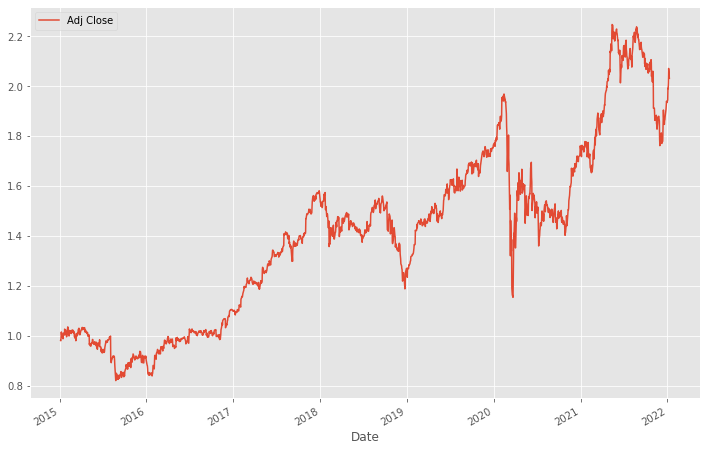

            Adj Close
Date                 
2015-01-31   1.003152
2015-02-28   1.016566
2015-03-31   1.006423
2015-04-30   1.020174
2015-05-31   0.974137
...               ...
2021-09-30   2.141936
2021-10-31   2.072252
2021-11-30   1.892620
2021-12-31   1.847039
2022-01-31   2.006389

[85 rows x 1 columns]


<AxesSubplot:xlabel='Date'>

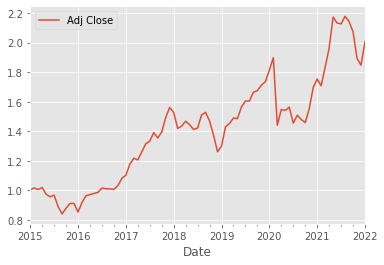

In [10]:
#Now let's take a quick look at cumulative returns
cum_daily_returns = (1 + daily_pct_change).cumprod()
print(cum_daily_returns) #basically would have 12x your money

cum_daily_returns.plot(grid = True, figsize = (12, 8))
plt.show()

#Let's do cum month too
cum_monthly_returns = cum_daily_returns.resample('M').mean()
print(cum_monthly_returns)
cum_monthly_returns.plot(grid = True)

In [11]:
#What have we learned?
#Visually, we see that the allstate price and returns are not normally distributed
#This is true for daily, monthly, and quarterly series
#time to go towards some more traditional time series EDA and prediction
#We will use ADF, KPSS, p/acf and ARIMA!

#but for now, let's take a break!